## Setup

You might need to install arcgis in order to proceed.

In [1]:
from arcgis.gis import GIS
from arcgis.features import FeatureLayer, use_proximity
import time
import pandas as pd
import datetime as dt
import numpy as np
import networkx as nx
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
from collections import defaultdict
import itertools
import matplotlib.pyplot as plt
from copy import deepcopy
import math

Get GIS map and data for neighborhoods in NYC.

In [2]:
gis = GIS()
m = gis.map('New York City')
url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/Neighborhood_Names/FeatureServer/0'
layer = FeatureLayer(url)

m.add_layer(layer)
m.zoom = 9

m

MapView(layout=Layout(height='400px', width='100%'))

Obtain spatial dataframe from feature layer and dispaly.

In [3]:
df = pd.DataFrame.spatial.from_layer(layer)
df = df[df['Borough'].isin(['Manhattan'])]
df.reset_index(inplace = True)
del df['index']
df

,FID,Name,Stacked,AnnoLine1,AnnoLine2,AnnoLine3,AnnoAngle,Borough,SHAPE
0,8,Marble Hill,2,Marble,Hill,,0,Manhattan,"{""x"": -8227697.156347497, ""y"": 4994151.1694602..."
1,106,Inwood,1,Inwood,,,0,Manhattan,"{""x"": -8228871.662274224, ""y"": 4992845.8452665..."
2,109,Hamilton Heights,2,Hamilton,Heights,,0,Manhattan,"{""x"": -8232041.763434119, ""y"": 4986359.2671384..."
3,112,Manhattanville,2,Manhattanville,,,0,Manhattan,"{""x"": -8232898.64262594, ""y"": 4985378.13522187..."
4,115,Central Harlem,2,Central,Harlem,,0,Manhattan,"{""x"": -8231320.769875514, ""y"": 4985237.1688914..."
5,116,Carnegie Hill,2,Carnegie,Hill,,0,Manhattan,"{""x"": -8232439.012401979, ""y"": 4980341.2592270..."
6,118,East Harlem,2,East,Harlem,,0,Manhattan,"{""x"": -8231428.872713471, ""y"": 4981747.8492937..."
7,119,Noho,1,Noho,,,0,Manhattan,"{""x"": -8236354.922567473, ""y"": 4971608.9421025..."
8,121,Upper East Side,3,Upper,East,Side,0,Manhattan,"{""x"": -8233246.208383483, ""y"": 4979305.7332626..."
9,122,Civic Center,2,Civic,Center,,0,Manhattan,"{""x"": -8238245.30824261, ""y"": 4970429.5136748,..."


Plot Manhattan data.

In [4]:
map_manhattan = gis.map('New York City')
df.spatial.plot(map_widget= map_manhattan,
                symbol_type='simple',
                colors='Reds_r',
                symbol_style='d', 
                outline_color='Blues',
                marker_size=9)
map_manhattan.zoom = 11

In [5]:
map_manhattan

MapView(layout=Layout(height='400px', width='100%'))

## Network Model

First, we need to build the edges using Voronoi Diagram and Delaunay Triangulation.

In [6]:
x_coord = [shape['x'] for shape in df['SHAPE']]
y_coord = [shape['y'] for shape in df['SHAPE']]
points = np.c_[x_coord,y_coord]

vor = Voronoi(points)

The cell below is used to plot finite Voronoi polygons. Credits to pv. on Stackoverflow. This is only used to plot the Voronoi cells to make the network graph clearer. It has not substantially value in building the network edges (hence I used external code)

In [7]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060]
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

Plot Voronoi cells and Delaunay Triangulation. Delaunay triangles can be obtained using scipy.spatial.

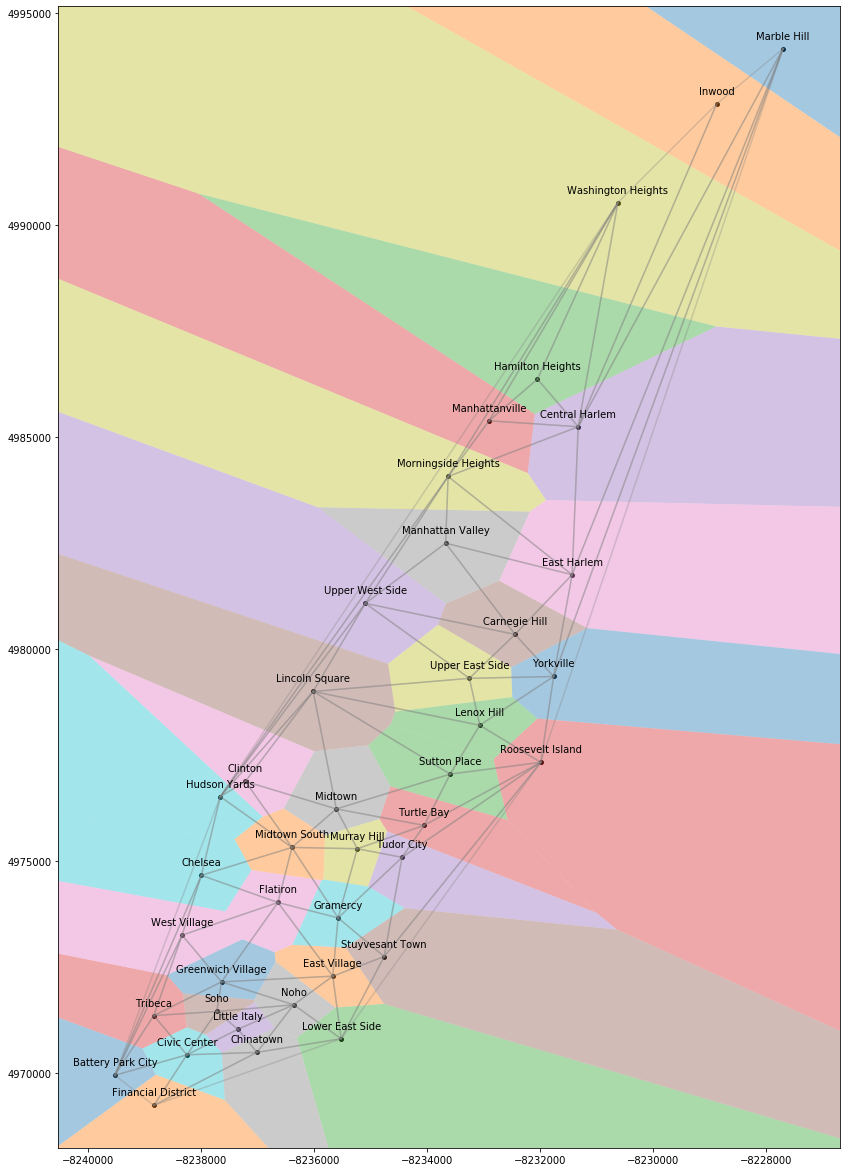

In [8]:
regions, vertices = voronoi_finite_polygons_2d(vor)
plt.figure(figsize = (14,21))

for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.scatter(points[:,0], points[:,1],s=15,c='black')
plt.xlim(vor.min_bound[0] - 1000, vor.max_bound[0] + 1000)
plt.ylim(vor.min_bound[1] - 1000, vor.max_bound[1] + 1000)
for i, txt in enumerate(df['Name']):
    plt.annotate(txt,points[i],textcoords="offset points",xytext=(0,10),ha='center')

# Find Delaunay triangles and connect the edges
tri = Delaunay(points)
neighbor_dict=defaultdict(set)
for p in tri.vertices:
    for i,j in itertools.combinations(p,2):
        neighbor_dict[df['Name'][i]].add(df['Name'][j])
        neighbor_dict[df['Name'][j]].add(df['Name'][i])
        
        plt.plot([points[i,0],points[j,0]],[points[i,1],points[j,1]],c='grey',alpha=0.3)

plt.show()


Print the neighbors.

In [9]:
for key, item in neighbor_dict.items():
    print("%s:%s" % (key,', '.join([i for i in item])))
    print('\n')

Hudson Yards:Clinton, Battery Park City, Washington Heights, Upper West Side, Chelsea, Lincoln Square, Midtown South, Morningside Heights


Lincoln Square:Clinton, Upper East Side, Upper West Side, Sutton Place, Lenox Hill, Hudson Yards, Midtown


Upper West Side:Carnegie Hill, Upper East Side, Lincoln Square, Manhattan Valley, Hudson Yards, Morningside Heights


Central Harlem:Washington Heights, Manhattanville, Hamilton Heights, Inwood, East Harlem, Morningside Heights, Marble Hill


East Harlem:Central Harlem, Carnegie Hill, Manhattan Valley, Yorkville, Morningside Heights, Marble Hill


Marble Hill:Central Harlem, Roosevelt Island, Inwood, East Harlem, Yorkville


Roosevelt Island:Tudor City, Sutton Place, Turtle Bay, Stuyvesant Town, Lenox Hill, Lower East Side, Yorkville, Marble Hill


Stuyvesant Town:East Village, Gramercy, Tudor City, Roosevelt Island, Lower East Side


Lower East Side:East Village, Chinatown, Roosevelt Island, Financial District, Stuyvesant Town, Noho


Tribec

Calculate distances between connected edges.

In [10]:
def distance(point1, point2):
    # The data uses UTM coordinate system, which places all locations on a 2-d planes.
    # We can directly calculate the Euclidean distance to approximate the actual distance between places

    x1, y1, x2, y2 = point1[0], point1[1], point2[0], point2[1]

    return ((x1-x2)**2 + (y1-y2)**2)**0.5

In [11]:
dist_mat = np.zeros((len(df),len(df)))

for i in range(len(df)):
    for j in range(i+1,len(df)):
        point1 = [df['SHAPE'][i]['x'], df['SHAPE'][i]['y']]
        point2 = [df['SHAPE'][j]['x'], df['SHAPE'][j]['y']]
        dist_mat[i,j] = distance(point1, point2)
        dist_mat[j,i] = dist_mat[i,j]
        
dist_mat = pd.DataFrame(dist_mat)
dist_mat.columns = df['Name']
dist_mat.index = df['Name']
dist_mat

Name,Marble Hill,Inwood,Hamilton Heights,Manhattanville,Central Harlem,Carnegie Hill,East Harlem,Noho,Upper East Side,Civic Center,...,Battery Park City,Financial District,Sutton Place,Turtle Bay,Tudor City,Stuyvesant Town,Flatiron,Chinatown,Washington Heights,Hudson Yards
Name,,,,,,,,,,,,,,,,,,,,,
Marble Hill,0.000000,1755.942887,8921.286484,10199.097472,9622.368791,14601.329374,12952.530957,24147.648543,15848.626262,25961.133673,...,26939.035674,27288.505266,18088.137058,19383.337552,20223.272773,22538.419543,22025.790828,25429.401899,4657.923930,20252.303479
Inwood,1755.942887,0.000000,7219.780965,8484.295142,7993.127312,13003.486415,11388.803267,22516.776870,14229.240554,24297.266529,...,25255.279630,25623.280258,16485.829535,17778.340215,18613.227756,20942.918030,20363.435594,23792.697801,2906.214917,18542.089205
Hamilton Heights,8921.286484,7219.780965,0.000000,1302.636475,1333.767666,6031.104871,4651.968355,15368.000207,7155.629097,17095.058163,...,18037.386225,18418.932202,9438.060791,10711.096859,11526.606021,13880.833790,13166.150540,16630.636414,4400.366889,11331.247575
Manhattanville,10199.097472,8484.295142,1302.636475,0.000000,1584.157165,5057.803845,3916.529014,14196.356934,6082.340628,15876.023412,...,16793.425646,17196.571608,8358.087109,9609.398110,10408.075318,12767.675746,11956.616882,15447.390742,5627.613230,10057.803143
Central Harlem,9622.368791,7993.127312,1333.767666,1584.157165,0.000000,5021.991417,3490.993767,14528.291666,6236.123962,16346.739265,...,17351.488297,17674.782026,8496.263088,9787.068011,10620.513100,12954.400321,12412.017081,15808.028438,5332.331193,10778.677750
Carnegie Hill,14601.329374,13003.486415,6031.104871,5057.803845,5021.991417,0.000000,1731.726828,9570.147062,1312.965870,11487.200324,...,12578.600790,12812.161070,3486.833769,4782.282448,5624.119595,7940.224773,7586.802978,10861.226696,10343.279369,6468.225092
East Harlem,12952.530957,11388.803267,4651.968355,3916.529014,3490.993767,1731.726828,0.000000,11272.240514,3044.115577,13212.437871,...,14309.858421,14536.175119,5170.770540,6464.410125,7311.446626,9596.339133,9317.574684,12566.368863,8812.532532,8132.373080
Noho,24147.648543,22516.776870,15368.000207,14196.356934,14528.291666,9570.147062,11272.240514,0.000000,8300.885377,2228.140349,...,3575.985153,3428.123684,6103.786204,4817.183922,3968.944936,1963.677346,2427.447611,1297.245370,19764.912247,5076.316337
Upper East Side,15848.626262,14229.240554,7155.629097,6082.340628,6236.123962,1312.965870,3044.115577,8300.885377,0.000000,10187.162194,...,11268.649427,11513.478884,2282.774810,3559.467660,4386.304443,6730.797926,6278.433683,9586.892041,11521.010690,5217.186195


Build the graph and add relevant attributes.

In [12]:
G = nx.Graph()
G.add_nodes_from(df['Name'])

In [13]:
for key, item in neighbor_dict.items():
    for an_item in item:
        G.add_edge(key, an_item,weight = dist_mat[key][an_item])

The population of Manhattan is around 1.6 million in 2018. On average, there will be 40000 per neighborhood. Since there is no exact population data by neighborhood, I create fictional population data here.

In [14]:
# Population data:
population = {
            'Marble Hill':9481, 'Inwood':58946, 'Hamilton Heights':47531, 'Manhattanville':40568,
              'Central Harlem':118665, 'Carnegie Hill':45812, 'East Harlem':115921, 'Noho':5579,
              'Upper East Side':124231, 'Civic Center':3931, 'Yorkville':35221, 'Midtown South':28630,
              'Lenox Hill':88459, 'Roosevelt Island':11682, 'Upper West Side':214744,
              'Lincoln Square':40761, 'Clinton':45884, 'Midtown':104753, 'Murray Hill':10864,
              'Chelsea':47325, 'Greenwich Village':30591, 'East Village':63347, 'Lower East Side':72957,
              'Tribeca':17362, 'Little Italy':5000, 'Soho':19573, 'West Village':30738,
              'Manhattan Valley':92805, 'Morningside Heights':31884, 'Gramercy':27988, 
              'Battery Park City':9252, 'Financial District':57627, 'Sutton Place':31125,
              'Turtle Bay':24856, 'Tudor City':15801, 'Stuyvesant Town':21049, 'Flatiron':14380,
              'Chinatown':47844, 'Washington Heights':201590, 'Hudson Yards':70150
}

# ER room data:
ER_rooms = {
        'Washington Heights':4, 'Central Harlem':1, 'Morningside Heights':1, 'East Harlem':3,
        'Lenox Hill':2, 'Financial District':1, 'Greenwich Village':1 ,'Clinton':1, 'Stuyvesant Town':1,
        'Gramercy':2, 'Inwood': 1
           }

In [15]:
# Add node attributes

for node in G.nodes:
    G.nodes[node]['population'] = population[node]
    
    if node in list(ER_rooms.keys()):        
        G.nodes[node]['depot'] = ER_rooms[node]
    else:
        G.nodes[node]['depot'] = 0

    G.nodes[node]['patient'] = 0
    G.nodes[node]['countdown'] = [] # see simulation code for further explanation
    G.nodes[node]['begin'] = [] # variable storing the begin time of the emergency
    G.nodes[node]['end'] = [] # variable storing the end time of the emergency

## Simulation

In [16]:
class Simulation():
    
    def __init__(self, G, ambulance = False, ambulance_dict = None):
        '''
        Initialize the simulation.
        --------
        Parameters
        
        ambulance: Indicator of whether the number of ambulance is limited.
        ambulance_dict: Dictionary of {node: number of ambulances}
        
        '''
        self.graph = G
        self.depot_neighborhoods = [node for node in self.graph.nodes if G.nodes[node]['depot'] > 0] # neighborhoods with ambulances
        self.ambulance_capacity = ambulance
        self.time = 0 # time 
        
        # Store np.cumsum array for patient generation (see Simulation.generate_patients())
        key_list = []
        value_list = []
        for key, value in nx.get_node_attributes(self.graph,'population').items():
            key_list.append(key)
            value_list.append(value)
        
        # These two variables are used to generate patients
        self.prob = np.cumsum(value_list)
        self.prob_key = key_list
        
        self.set_ambulance(ambulance_dict)
        self.layout = nx.spring_layout(self.graph)
        
       
    
    def set_ambulance(self, ambulance_dict):   
        '''
        Set number of ambulances in each depot based on the ambulance_dict
        '''
        
        nx.set_node_attributes(self.graph, 0, 'ambulance')
        
        if self.ambulance_capacity:
            for depot, num in ambulance_dict.items():
                self.graph.nodes[depot]['ambulance'] = num
    
        
        
    def display(self, content = 'neighborhood_state'):
        '''
        Draw the state of the network. The color of the nodes indicates the specified content.
        The color of the edges indicates weight. The size of the nodes indicates population.
        --------
        Parameters
        
        content: 'neighborhood_state' or 'total_treated' or 'average_time'
                    'neighborhood_state' draws the current number of active patients that have not been
                    assigned an ambulance. 'total_treated' draws the total number of patients dealt with
                    on the node. 'average_time' draws average response time of the node.
        '''
        
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=200, k = 0.6)
        plt.clf()
        plt.figure(figsize=(20,20))
        
        node_size = list(nx.get_node_attributes(self.graph,'population').values())
        node_size = [s * 0.02 for s in node_size] # node size proportional population
        
        
        if content == 'neighborhood_state':

            nx.draw(
                self.graph, pos=self.layout, with_labels=True,
                node_size = node_size,
                node_color=[self.graph.nodes[i]['patient'] for i in self.graph.nodes],
                cmap = plt.cm.coolwarm,
                font_size = 14,
                edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
                edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=5000,
                alpha=0.8, font_weight = 'bold'
                )
        
            plt.title('Network state after %d minutes' % self.time, size = 20)
        
        
        if content == 'total_treated':

            nx.draw(
                self.graph, pos=self.layout, with_labels=True,
                node_size = node_size,
                node_color=[len(self.graph.nodes[i]['countdown']) for i in self.graph.nodes],
                cmap = plt.cm.coolwarm,
                font_size = 14,
                edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
                edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=5000,
                alpha=0.8, font_weight = 'bold'
                )
            
            plt.title('Total treated patients in the neighborhood after %d minutes' % self.time, size = 20)
        
        
        if content == 'average_time':
            
            avg_node_time, node_time = self.calc_response_time()

            nx.draw(
                self.graph, pos=self.layout, with_labels=True,
                node_size = node_size,
                node_color=[np.mean(node_time[i]) for i in self.graph.nodes], # average response time
                cmap = plt.cm.coolwarm,
                font_size = 14,
                edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
                edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=5000,
                alpha=0.8, font_weight = 'bold'
                )
        
            plt.title('Average response time of the neighborhood', size = 20)
            
        plt.show()
        
        
        
    def call_ambulance(self, node):
        '''
        Call an ambulance.
        
        --------
        Parameters
        
        node: The node (neighborhood) that is calling the ambulance
        '''
        closest = None
        distance = float('inf')
        for neighborhood in self.depot_neighborhoods:
            new_dist = nx.bellman_ford_path_length(self.graph,node,neighborhood) # Find the weightest shortest path
            new_dist = max(0, new_dist + np.random.normal(0,200)) # Find the distance based on randomly generated fluctuations. Minimum distance is 0.
            
            # If there is limit on the number of ambulances, find the closest available ambulance.
            if self.ambulance_capacity:   
                if new_dist < distance and self.graph.nodes[neighborhood]['ambulance'] > 0:
                    closest = neighborhood
                    distance = new_dist
            else:
                if new_dist < distance:
                    closest = neighborhood
                    distance = new_dist
        
        # If can't find, return False and wait for next turn
        if closest == None or distance == float('inf'):
            return False, False
        else:
            self.graph.nodes[node]['patient'] -= 1
            return closest, distance

        
        
    def generate_patients(self, rate):
        '''
        Generate patients across neighborhoods. The probability of having a patient is proportional to
        the population in the neighborhood.
        --------
        Parameters
        
        rate: Number of patients generated per minute
        '''
        
        # Generate uniform numbers and use that to determine where to generate the patients
        patients = np.random.uniform(0,self.prob[-1],rate)
        
        for patient in patients:
            index = np.searchsorted(self.prob,patient) 
            neighborhood = self.prob_key[index]
            self.graph.nodes[neighborhood]['patient'] += 1
            self.graph.nodes[neighborhood]['begin'].append(self.time) # Record the starting time
            self.graph.nodes[neighborhood]['end'].append(None)
        

        
    def pick_up_patients(self, ER_node, patient_node, distance):
        '''
        Pick up a patient. Assume an ambulance moves at 250m/min (15km/h)
        --------
        Parameters
        
        ER_node: The node of the emergency room.
        patient_node: The node where the patient belongs to.
        distance: Distance from the ER_node to the patient node
        '''
        if self.ambulance_capacity:   
            self.graph.nodes[ER_node]['ambulance'] -= 1
        
        # Add [ER_node, time for traveling to, time for traveling back] for each ambulance to the countdown list.
        # See emergency_operation(self) for the update of the countdown list.
        # Minimum traveling time is 1 minute.
        self.graph.nodes[patient_node]['countdown'].append([ER_node, 
                                                            max(1,math.ceil(distance/250)), 
                                                            max(1,math.ceil(distance/250))
                                                           ])

        

        
    def update(self, patients_rate = 1):
        '''
        General update function
        '''
        
        self.generate_patients(rate = patients_rate)
        
        self.emergency_operation()
                            
        self.time += 1
     
    
    def emergency_operation(self):
        '''
        Function to go through each node and update patients and ambulances.
        '''
        
        for node in self.graph.nodes:
            # If there are patients that have not been assigned ambulances, call for ambulance.
            if self.graph.nodes[node]['patient'] > 0:
                for _ in range(self.graph.nodes[node]['patient']):
                    ER_node, distance = self.call_ambulance(node)      
                    if ER_node == False and distance == False:
                        continue # patient remain unanswered if can't find available ambulance
                    else:
                        self.pick_up_patients(ER_node, node, distance)
            
            # These are the indices of emergency calls in which the ambulance have not returned yet.
            unfinished = [x for x in range(len(self.graph.nodes[node]['end'])) 
                          if self.graph.nodes[node]['end'][x] == None]

            for i in unfinished:
                if i < len(self.graph.nodes[node]['countdown']):
                    # Extract the [ER_node, time for traveling to, time for traveling back] added upon picking up the patient
                    task = self.graph.nodes[node]['countdown'][i]
                    task[1] -= 1 # task[1] it the time for traveling to the patient. Decrease by 1 each step. 
                    # After the ambulance arrived at the patient node, i.e. "time for traveling to" decreased below 0.
                    if task[1] < 0:
                        task[2] -= 1 # the way back
                        # When "time for traveling back" also drops below 0, task is completed.
                        if task[2] <= 0:
                            self.graph.nodes[task[0]]['ambulance'] += 1 # add back the ambulance
                            self.graph.nodes[node]['end'][i] = self.time # record end time
    
    
    
    def converge(self):
        '''
        Until all emergencies are dealt, continue updating. In the meantime, stop generating patients.
        '''
        
        active = list(nx.get_node_attributes(self.graph,'end').values())
        while None in [item for sublist in active for item in sublist]:
            self.emergency_operation()
            active = list(nx.get_node_attributes(self.graph,'end').values())
            self.time += 1

    
    
    def calc_response_time(self):
        '''
        Calculate response time.
        --------
        Returns
        
        avg_node_time: List of average node response time, the mean of which is the average
                        response time of the network.
        node_time: Dictionary of lists of response time keyed by node.
        '''
        avg_node_time = []
        node_time = {}
        for node in self.graph.nodes:
            time = [t_n - t_0 + 1 for t_0, t_n in zip(self.graph.nodes[node]['begin'], self.graph.nodes[node]['end'])]
            node_time[node] = time
            if len(time) > 0:
                avg = sum(time)/len(time)
            else:
                avg = None
            avg_node_time.append(avg)
            
        return avg_node_time, node_time
   


    def draw_response(self, *args, whole = True):
        '''
        Draw distributions of response time.
        --------
        Parameters
        
        whole: Whether to draw the distributions of response time of the entire graph.
        *args: Nodes. The distribution of the nodes specified here will be drawn.
        '''
        
        plt.clf()
        avg_node_time, node_time = self.calc_response_time()
        
        avg_node_time = [x for x in avg_node_time if x != None]
        
        if whole:
            plt.hist(avg_node_time,bins = 20, density = True)
            plt.xlabel('Response Time')
            plt.ylabel('Density')
            plt.axvline(np.mean(avg_node_time),c = 'red',label = 'Mean response time')
            plt.legend()
            plt.show()
            print('Average response time in Manhattan:', np.mean(avg_node_time))
            
        for key in args:
            time = node_time[key]
            plt.hist(time, density = True)
            plt.xlabel('Response Time for %s' % key)
            plt.ylabel('Density')
            plt.axvline(np.mean(time),c = 'red',label = 'Mean response time')
            plt.legend()
            plt.show()
            print('Average response time in %s:' % key, np.mean(time))

Dictionary of ambulance distribution.

In [17]:
ambulance_dict = {
        'Washington Heights':20, 'Central Harlem':5, 'Morningside Heights':5, 'East Harlem':15,
        'Lenox Hill':10, 'Financial District':5, 'Greenwich Village':5 ,'Clinton':5, 'Stuyvesant Town':5,
        'Gramercy':10, 'Inwood': 5
           }

## Experiments

Simulate one network for 6 hours to observe.

/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


<Figure size 432x288 with 0 Axes>

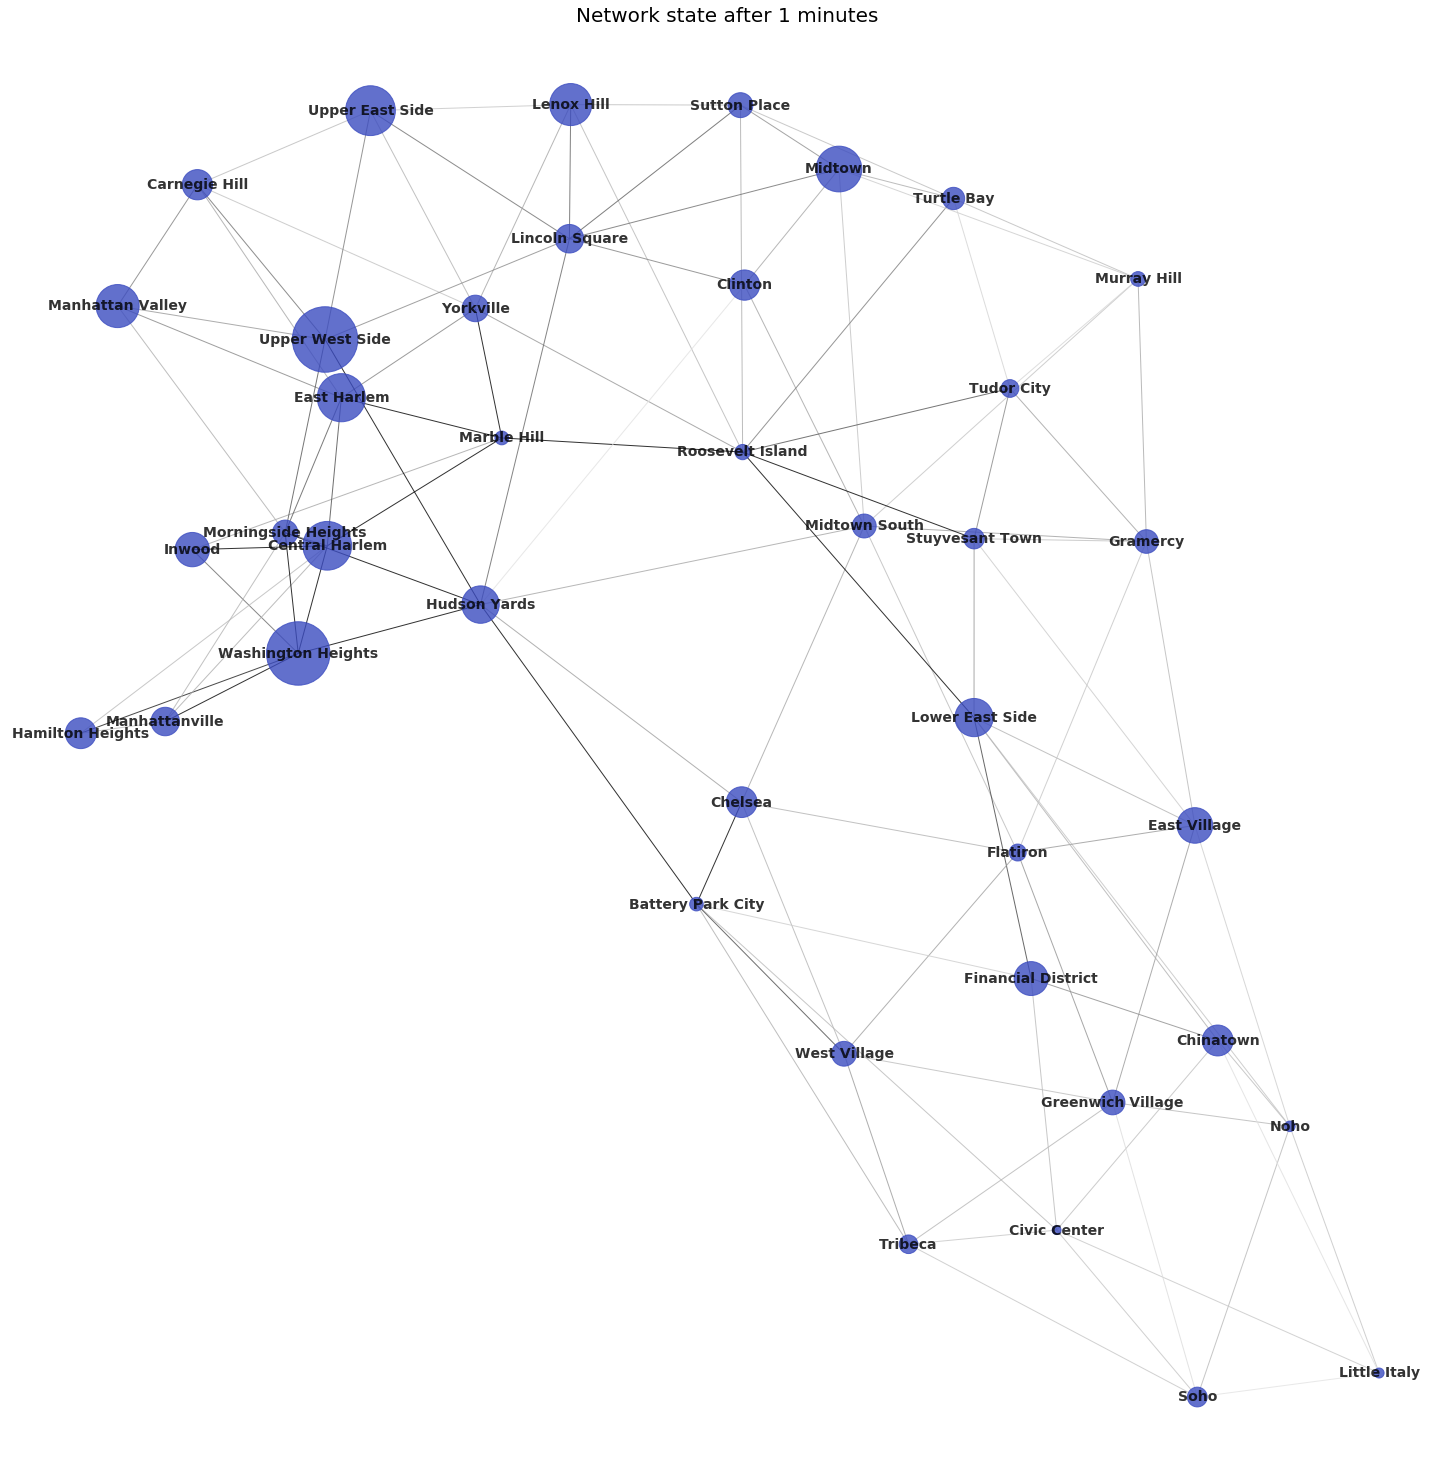

<Figure size 432x288 with 0 Axes>

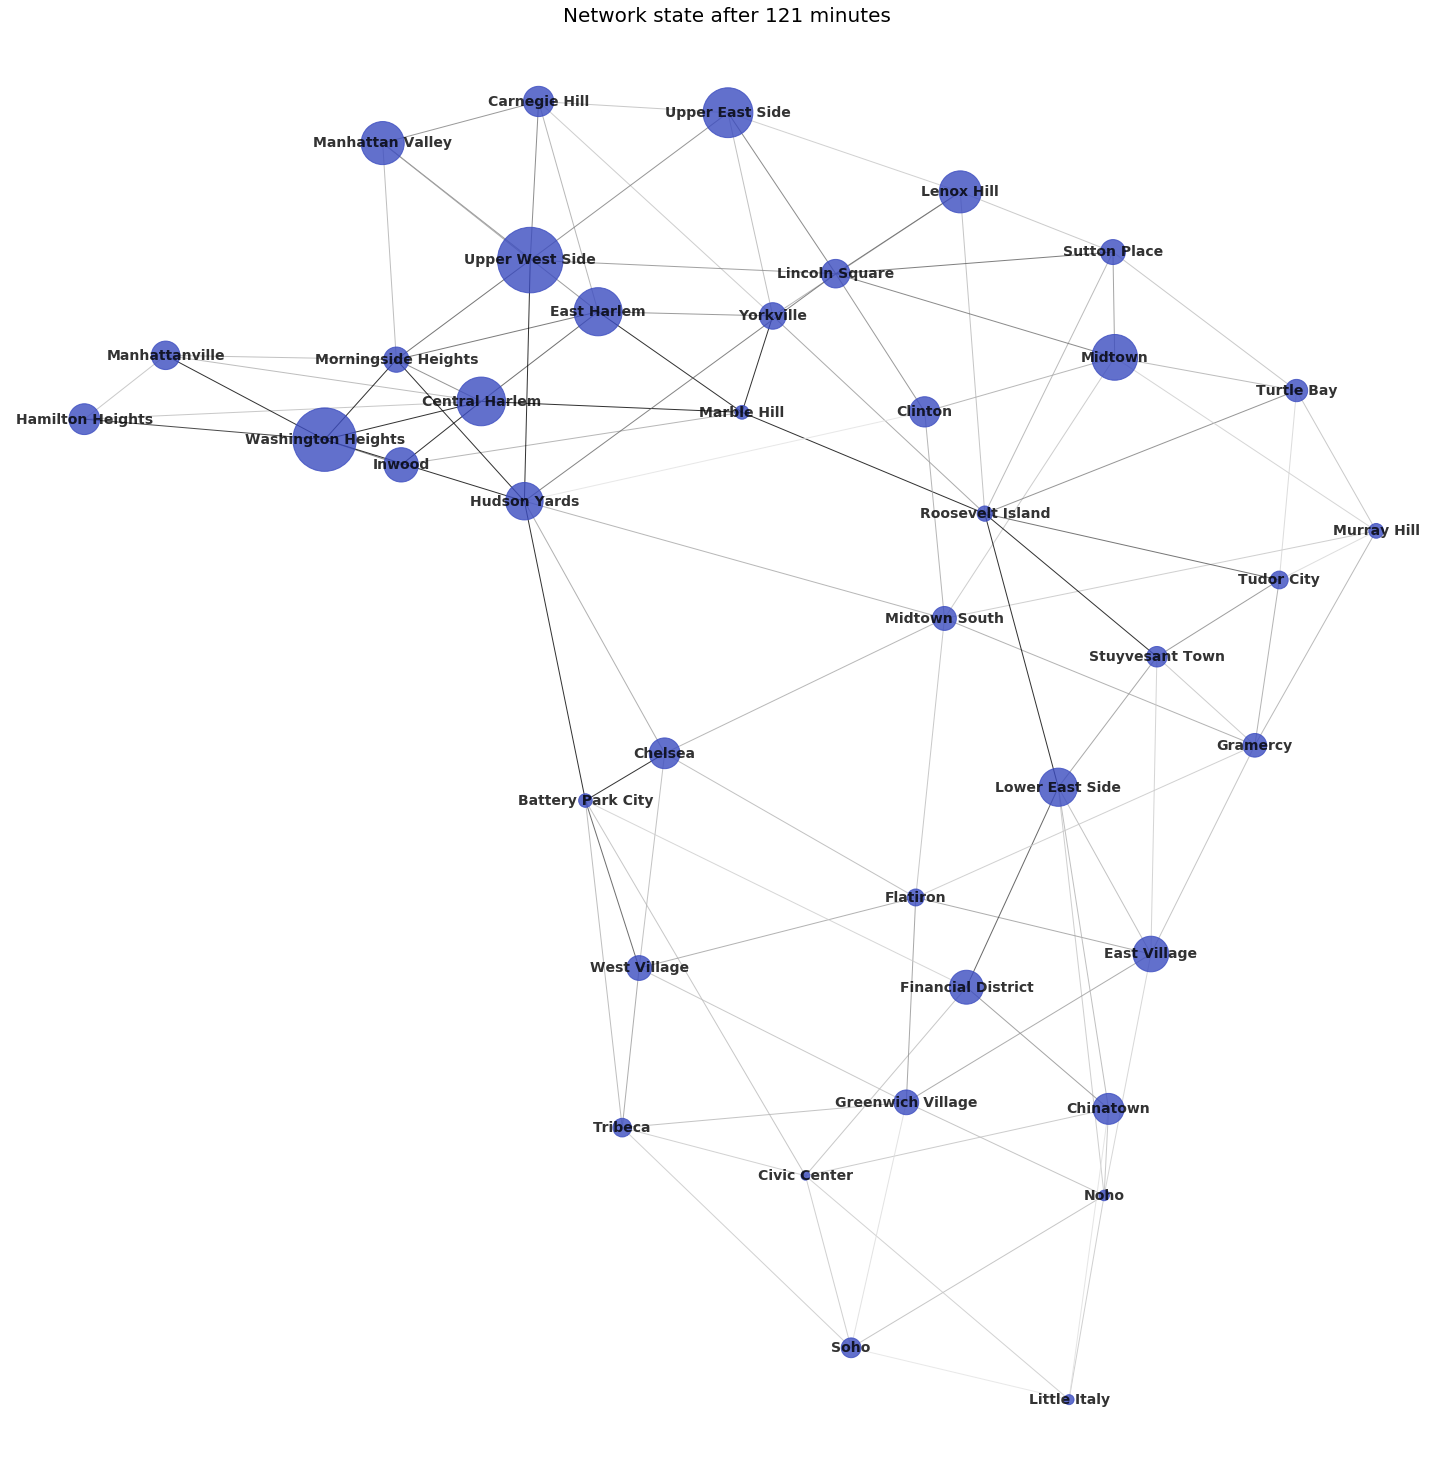

<Figure size 432x288 with 0 Axes>

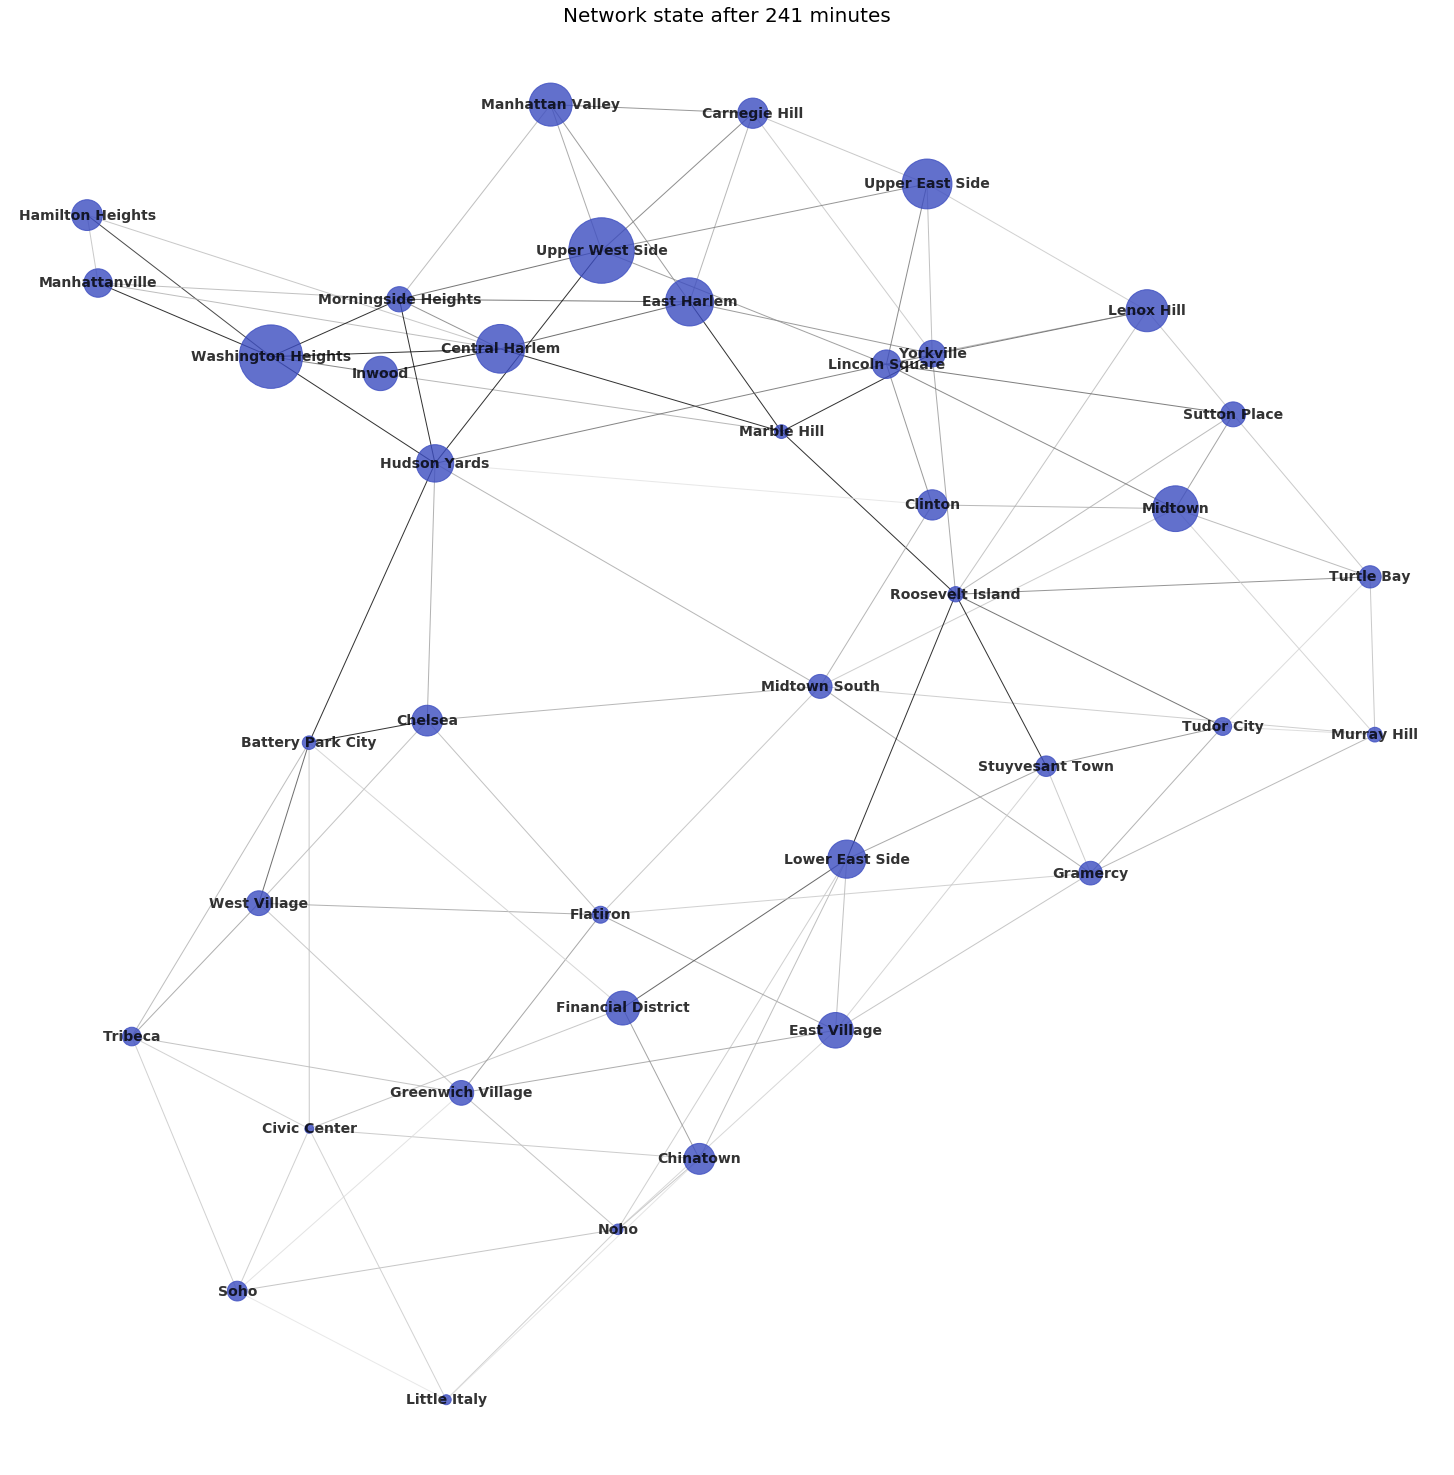

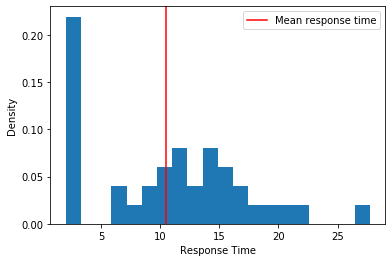

Average response time in Manhattan: 10.515283911664001


<Figure size 432x288 with 0 Axes>

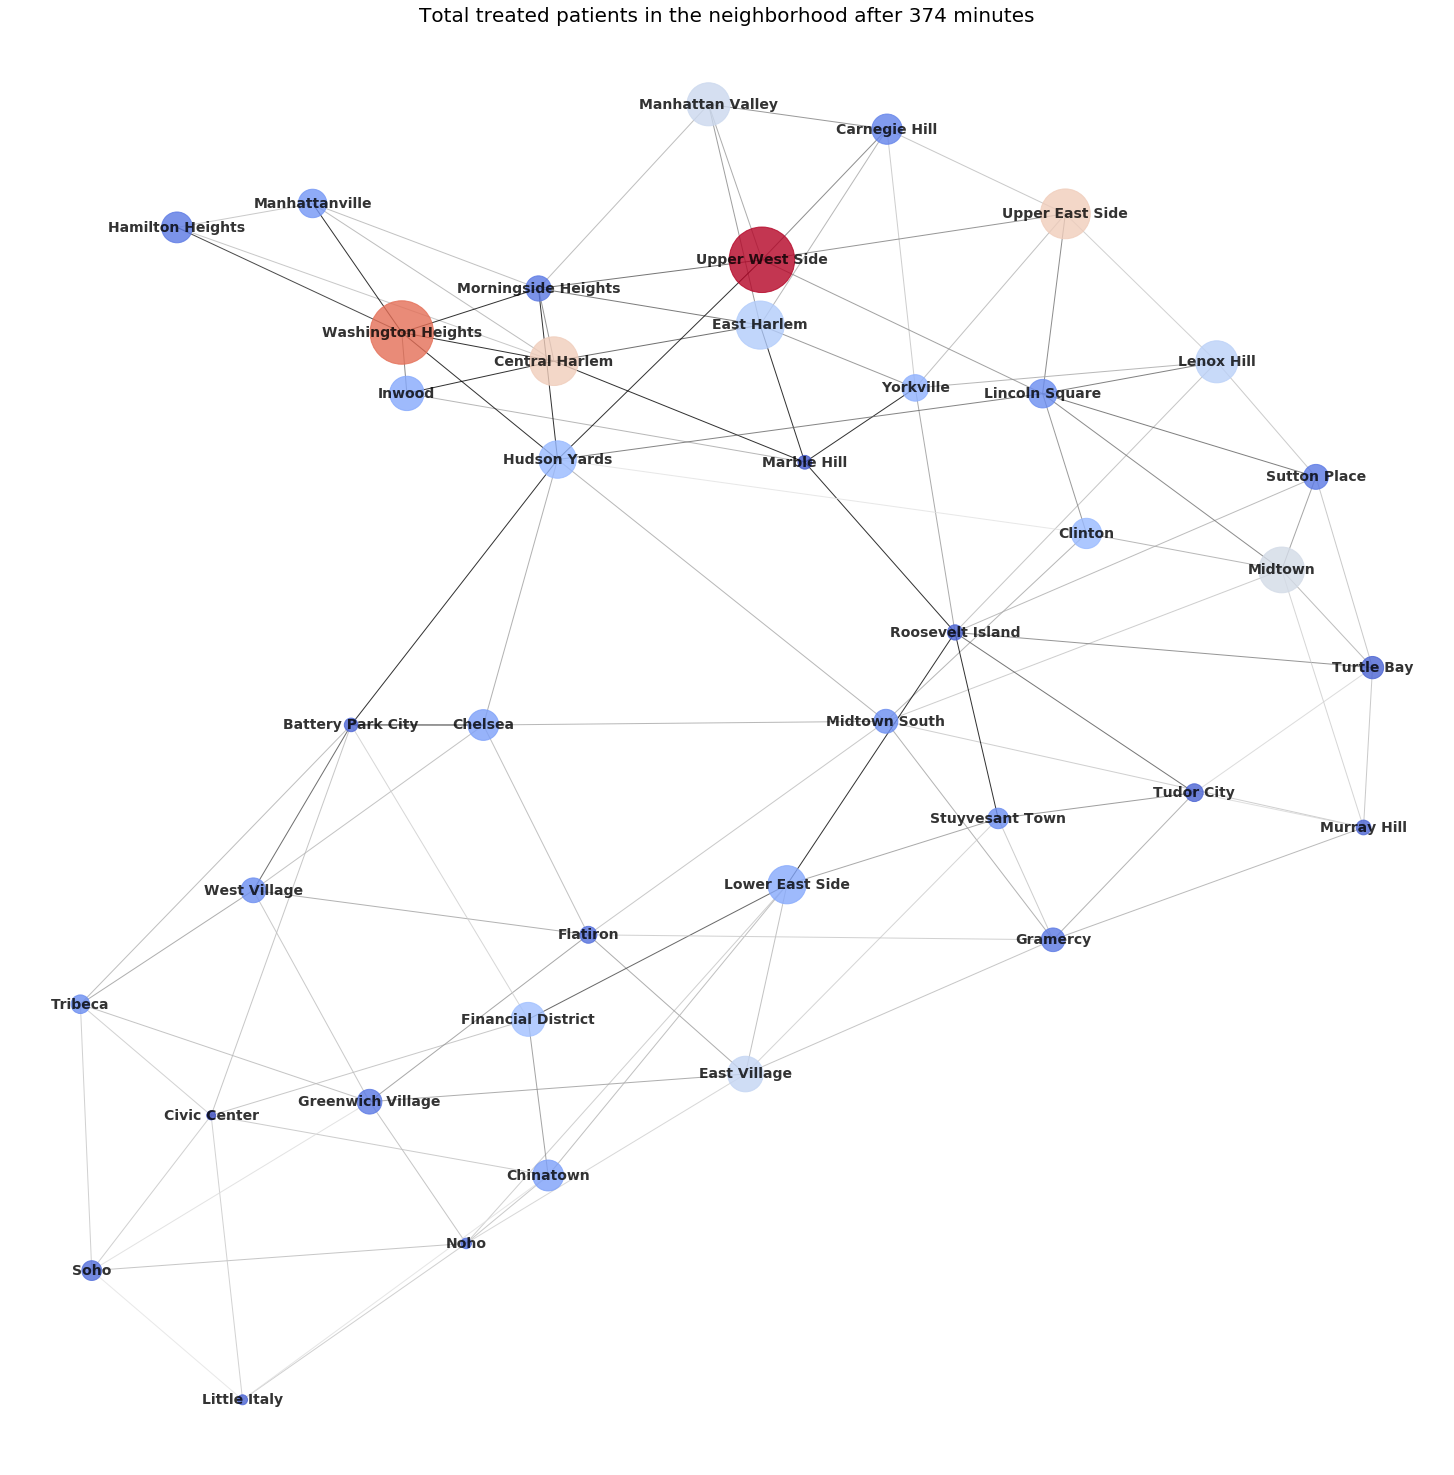

/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 432x288 with 0 Axes>

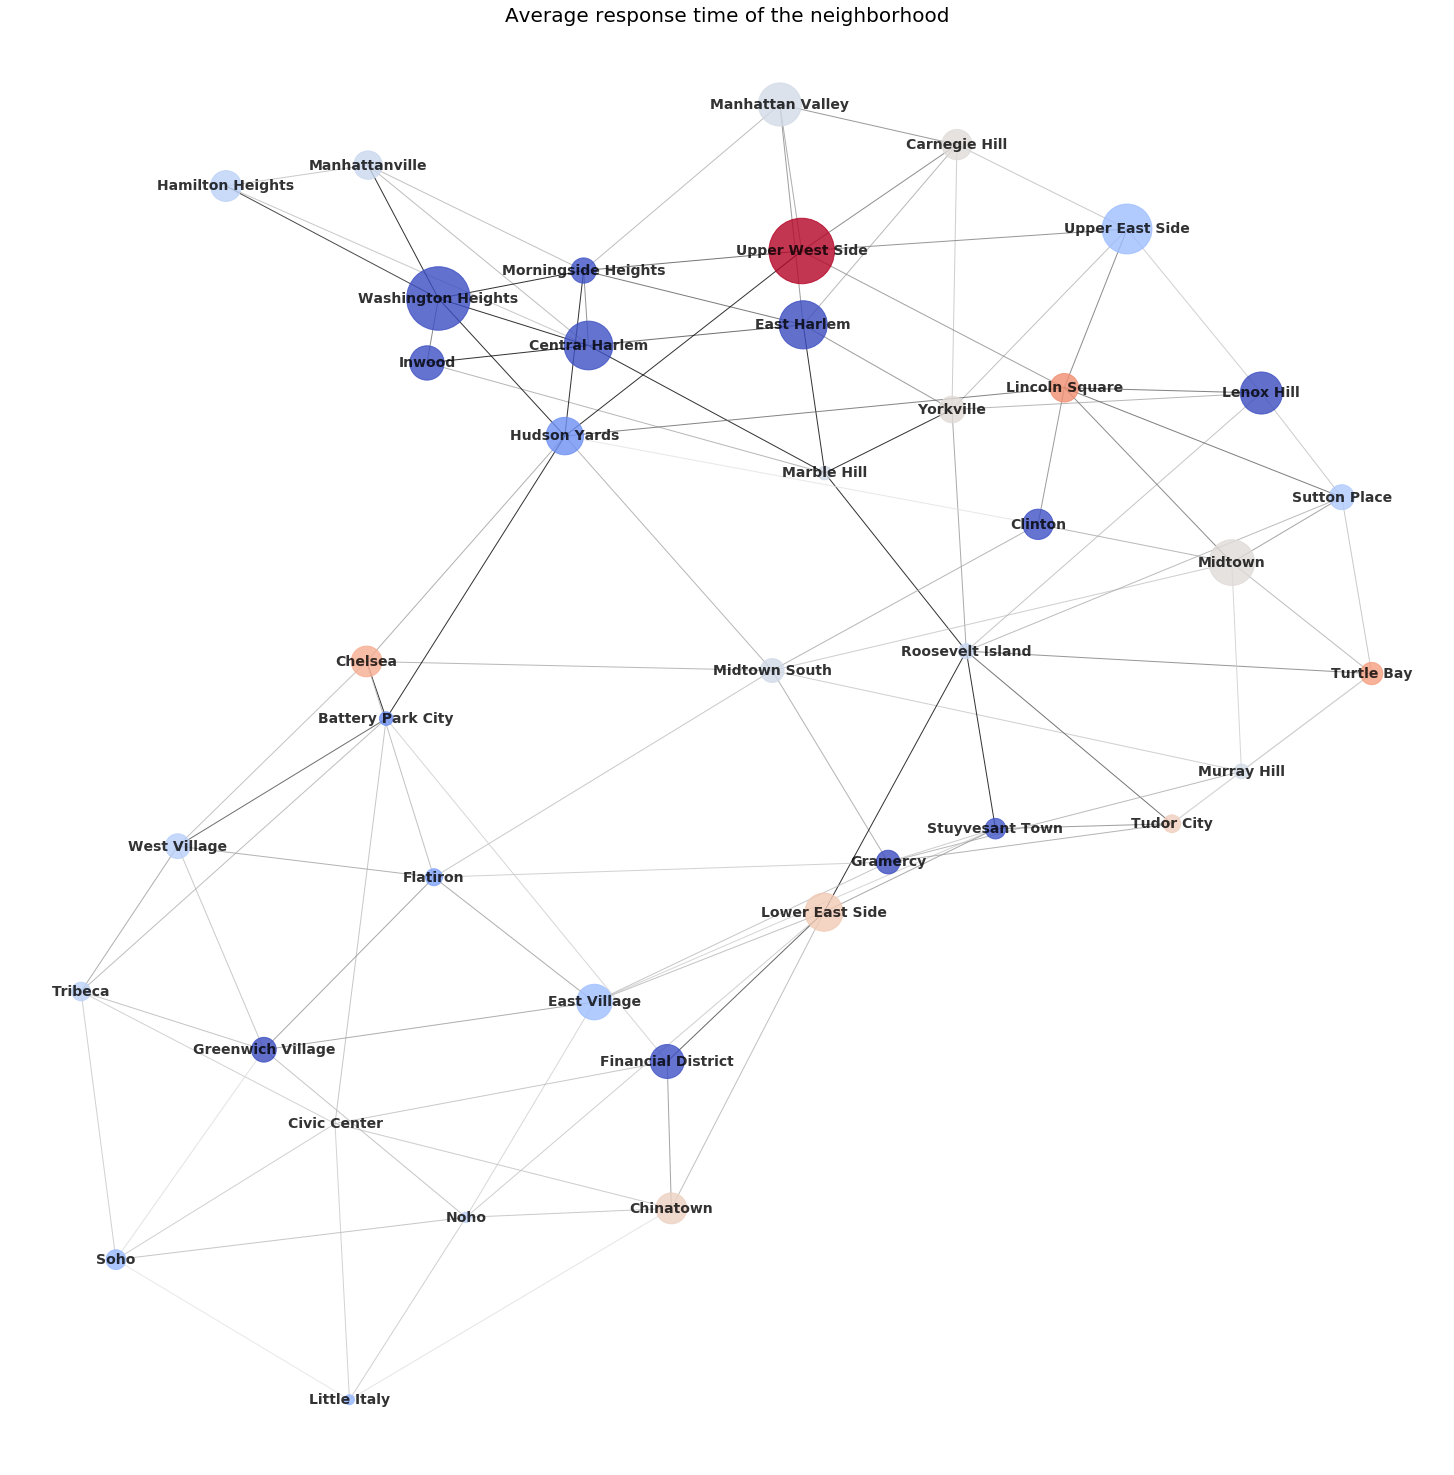

In [18]:
sim = Simulation(deepcopy(G),ambulance = True, ambulance_dict = ambulance_dict)
for i in range(360):
    sim.update()
    if i % 120 == 0:
        sim.display(content = 'neighborhood_state')
sim.converge()
    
sim.draw_response()
sim.display(content = 'total_treated')
sim.display(content = 'average_time')

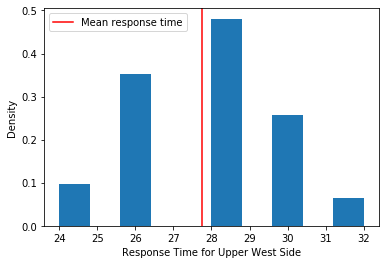

Average response time in Upper West Side: 27.743589743589745


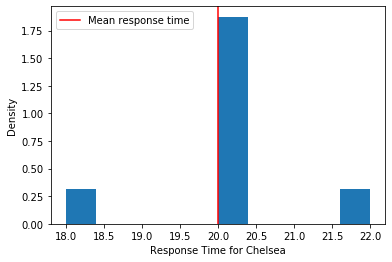

Average response time in Chelsea: 20.0


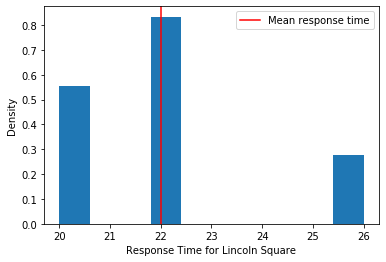

Average response time in Lincoln Square: 22.0


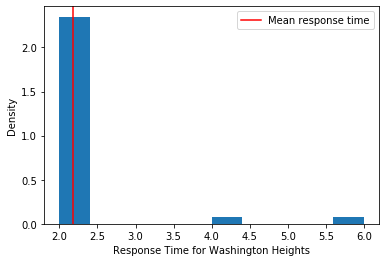

Average response time in Washington Heights: 2.1818181818181817


In [19]:
sim.draw_response('Upper West Side', 'Chelsea', 'Lincoln Square', 'Washington Heights', whole=False)

Monte Carlo simulation results.

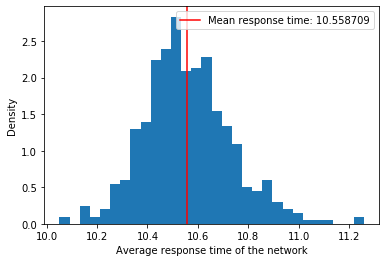

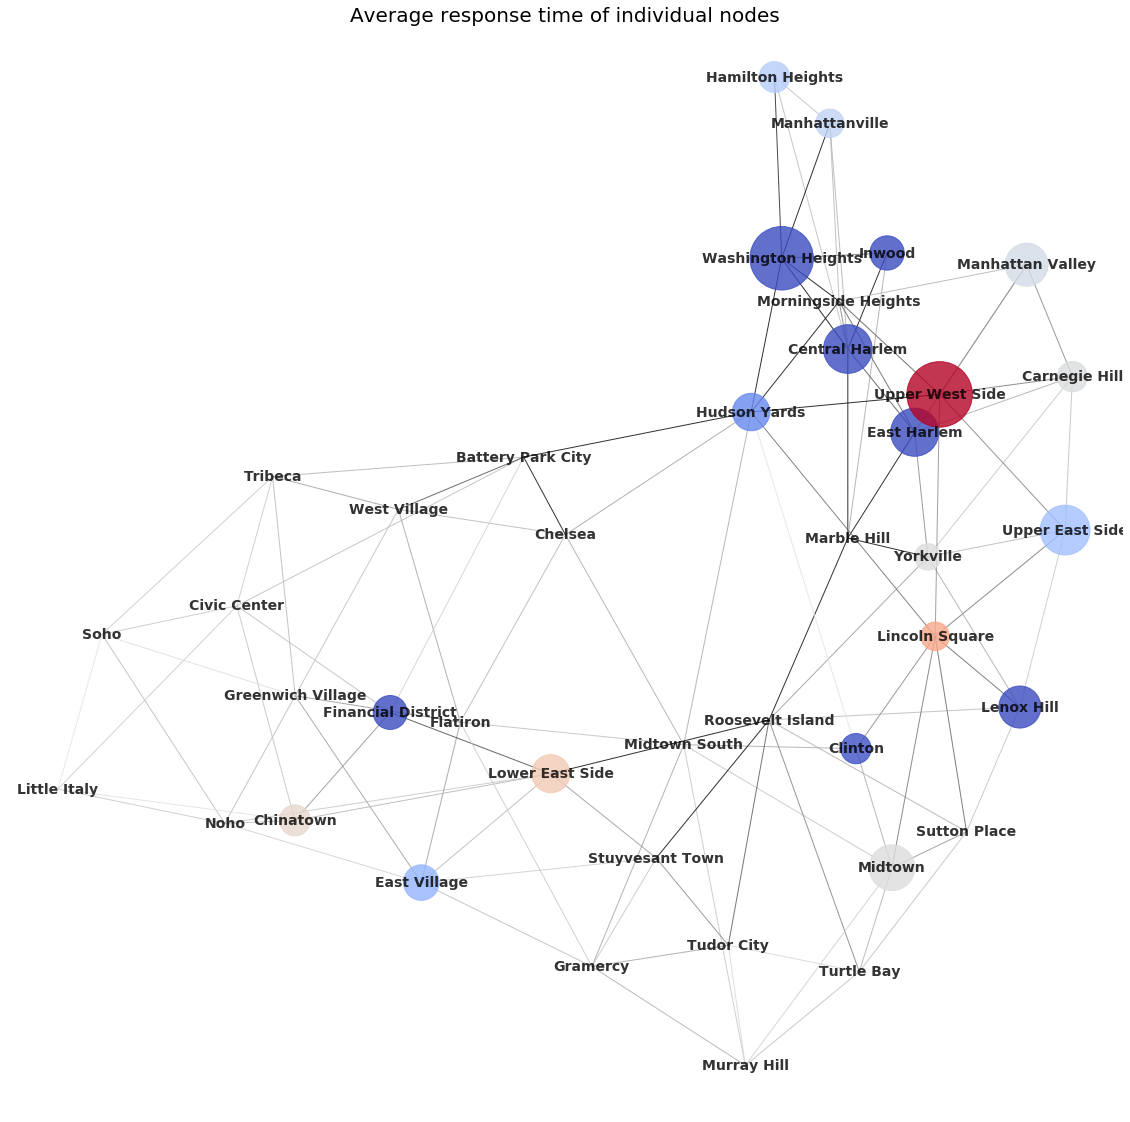

In [20]:
average_response_time_per_node = {key: 0 for key in G.nodes}
average_response_time_manhattan = []

for _ in range(500):  
    sim = Simulation(deepcopy(G),ambulance = True, ambulance_dict = ambulance_dict)
    for i in range(360):
        sim.update()
    sim.converge()
    avg_node_time, node_time = sim.calc_response_time()
    
    # Add the average response time of Manhattan
    avg_node_time = np.mean([x for x in avg_node_time if x != None])
    average_response_time_manhattan.append(avg_node_time)
    
    # Add the average response time keyed by node.
    for key, value in node_time.items():
        average_response_time_per_node[key] += np.mean(value)


## Visualize the results

# For the entire network
plt.hist(average_response_time_manhattan, bins = 30, density = True)
plt.xlabel('Average response time of the network')
plt.ylabel('Density')
plt.axvline(np.mean(average_response_time_manhattan), 
            label = 'Mean response time: %2f' % np.mean(average_response_time_manhattan), c = 'red')
plt.legend()
plt.show()

# For each node
plt.figure(figsize=(20,20))
average_response_time_per_node = {key: value/500 for key, value in average_response_time_per_node.items()}

layout = nx.spring_layout(G, iterations=200, k = 0.6)

node_size = list(nx.get_node_attributes(G,'population').values())
node_size = [s * 0.02 for s in node_size] # Node size proportional population

x_values, y_values = zip(*layout.values())
x_max = max(x_values)
x_min = min(x_values)
y_max = max(y_values)
y_min = min(y_values)
x_margin = (x_max - x_min) * 0.05
y_margin = (y_max - y_min) * 0.05
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.ylim(y_min - y_margin, y_max + y_margin)

nx.draw(
    G, pos=layout, with_labels=True,
    node_size = node_size,
    node_color=[average_response_time_per_node[i] for i in G.nodes],
    cmap = plt.cm.coolwarm,
    font_size = 14,
    edge_color=[G.edges[i, j]['weight'] for i, j in G.edges],
    edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=5000,
    alpha=0.8, font_weight = 'bold', #vmin=0, vmax=1
    )

plt.title('Average response time of individual nodes', size = 20)
plt.show()

**Solution A: Target-the-susceptible approach.**

In [21]:
ambulance_dict_new = {
        'Washington Heights':20, 'Central Harlem':5, 'Morningside Heights':5, 'East Harlem':15,
        'Lenox Hill':10, 'Financial District':5, 'Greenwich Village':5 ,'Clinton':5, 'Stuyvesant Town':5,
        'Gramercy':10, 'Inwood': 5, 'Upper West Side': 5, 'Lincoln Square': 5
           }

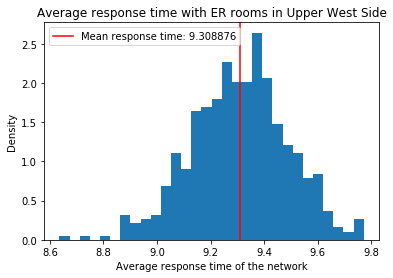

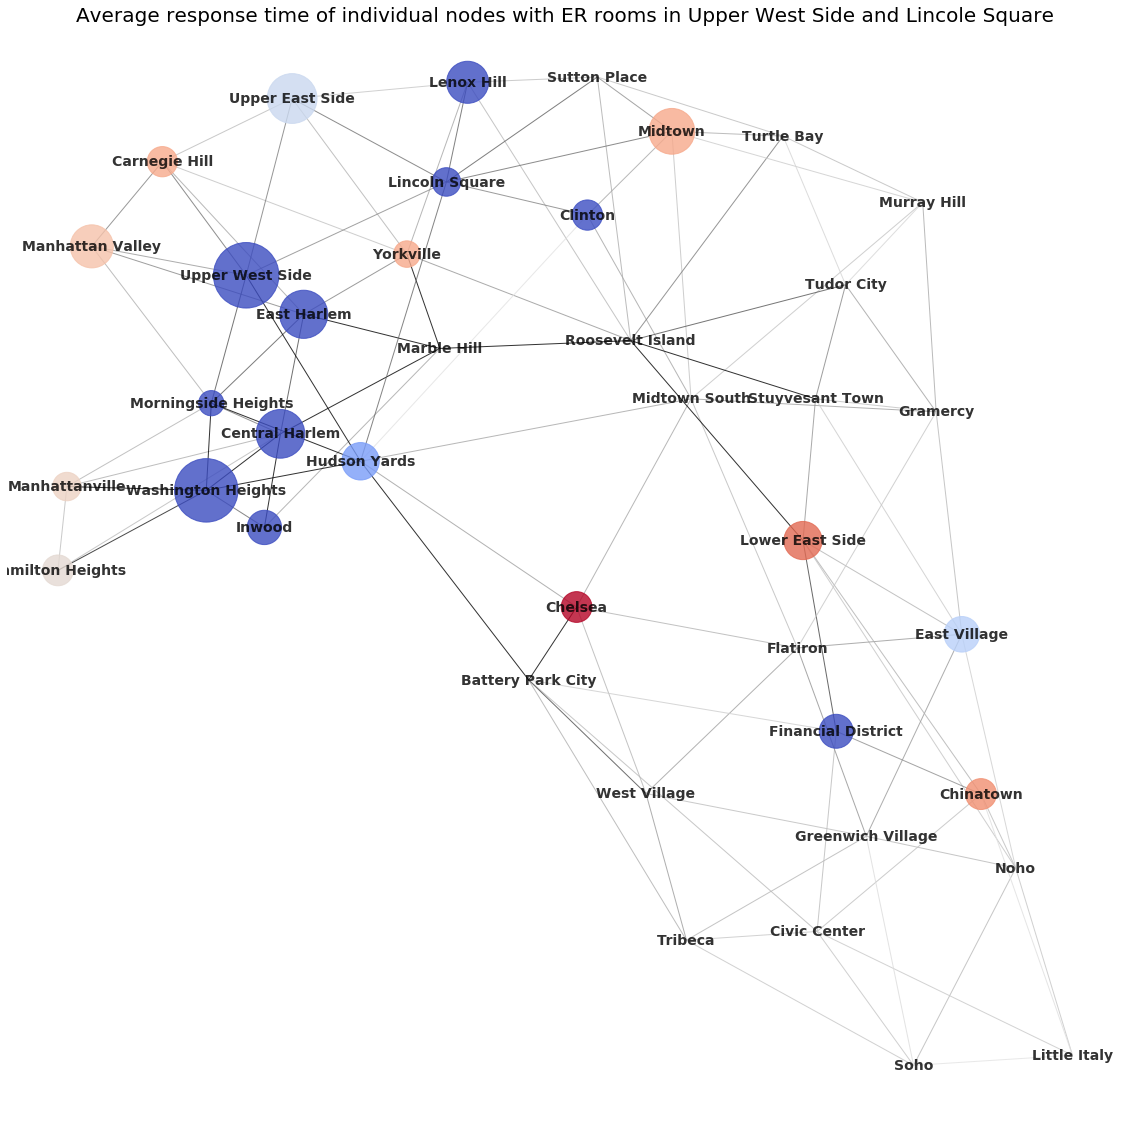

In [27]:
average_response_time_per_node = {key: 0 for key in G.nodes}
average_response_time_manhattan = []

for _ in range(500):  
    sim = Simulation(deepcopy(G),ambulance = True, ambulance_dict = ambulance_dict_new)
    sim.depot_neighborhoods.append('Upper West Side')
    sim.depot_neighborhoods.append('Lincoln Square')
    for i in range(360):
        sim.update()
    sim.converge()
    avg_node_time, node_time = sim.calc_response_time()
    
    # Add the average response time of Manhattan
    avg_node_time = np.mean([x for x in avg_node_time if x != None])
    average_response_time_manhattan.append(avg_node_time)
    
    # Add the average response time keyed by node.
    for key, value in node_time.items():
        average_response_time_per_node[key] += np.mean(value)


## Visualize the results

# For the entire network
plt.hist(average_response_time_manhattan, bins = 30, density = True)
plt.xlabel('Average response time of the network')
plt.ylabel('Density')
plt.title('Average response time with ER rooms in Upper West Side and Lincoln Square')
plt.axvline(np.mean(average_response_time_manhattan), 
            label = 'Mean response time: %2f' % np.mean(average_response_time_manhattan), c = 'red')
plt.legend()
plt.show()

# For each node
plt.figure(figsize=(20,20))
average_response_time_per_node = {key: value/500 for key, value in average_response_time_per_node.items()}

layout = nx.spring_layout(G, iterations=200, k = 0.6)

node_size = list(nx.get_node_attributes(G,'population').values())
node_size = [s * 0.02 for s in node_size] # Node size proportional population

x_values, y_values = zip(*layout.values())
x_max = max(x_values)
x_min = min(x_values)
y_max = max(y_values)
y_min = min(y_values)
x_margin = (x_max - x_min) * 0.05
y_margin = (y_max - y_min) * 0.05
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.ylim(y_min - y_margin, y_max + y_margin)

nx.draw(
    G, pos=layout, with_labels=True,
    node_size = node_size,
    node_color=[average_response_time_per_node[i] for i in G.nodes],
    cmap = plt.cm.coolwarm,
    font_size = 14,
    edge_color=[G.edges[i, j]['weight'] for i, j in G.edges],
    edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=5000,
    alpha=0.8, font_weight = 'bold', #vmin=0, vmax=1
    )

plt.title('Average response time of individual nodes with ER rooms in Upper West Side and Lincole Square', size = 20)
plt.show()

**Solution B: Betweenness centrality approach.**

In [23]:
betweenness = nx.betweenness_centrality(G,weight='weight')

print(sorted(betweenness.items(), key=lambda x: x[1],reverse=True))

[('Midtown', 0.2321187584345479), ('Sutton Place', 0.1970310391363023), ('Midtown South', 0.18758434547908232), ('Lenox Hill', 0.1808367071524966), ('Gramercy', 0.17273954116059378), ('Lincoln Square', 0.16464237516869096), ('East Village', 0.1592442645074224), ('Upper West Side', 0.14844804318488528), ('Morningside Heights', 0.14844804318488528), ('Flatiron', 0.14304993252361672), ('Greenwich Village', 0.13225371120107962), ('Turtle Bay', 0.12415654520917678), ('Noho', 0.11336032388663968), ('Tudor City', 0.11201079622132253), ('Yorkville', 0.10526315789473684), ('East Harlem', 0.0728744939271255), ('Murray Hill', 0.0728744939271255), ('Soho', 0.07152496626180836), ('Upper East Side', 0.06882591093117409), ('Hudson Yards', 0.06207827260458839), ('Chelsea', 0.05668016194331984), ('Washington Heights', 0.053981106612685556), ('Central Harlem', 0.04993252361673414), ('Carnegie Hill', 0.04588394062078272), ('Civic Center', 0.043184885290148446), ('Little Italy', 0.043184885290148446), ('W

Midtown and Sutton Place have the highest betweenness centrality

In [24]:
ambulance_dict_new2 = {
        'Washington Heights':20, 'Central Harlem':5, 'Morningside Heights':5, 'East Harlem':15,
        'Lenox Hill':10, 'Financial District':5, 'Greenwich Village':5 ,'Clinton':5, 'Stuyvesant Town':5,
        'Gramercy':10, 'Inwood': 5, 'Midtown': 5, 'Sutton Place': 5
           }

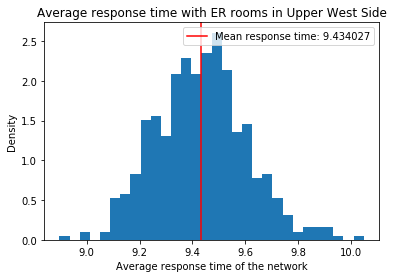

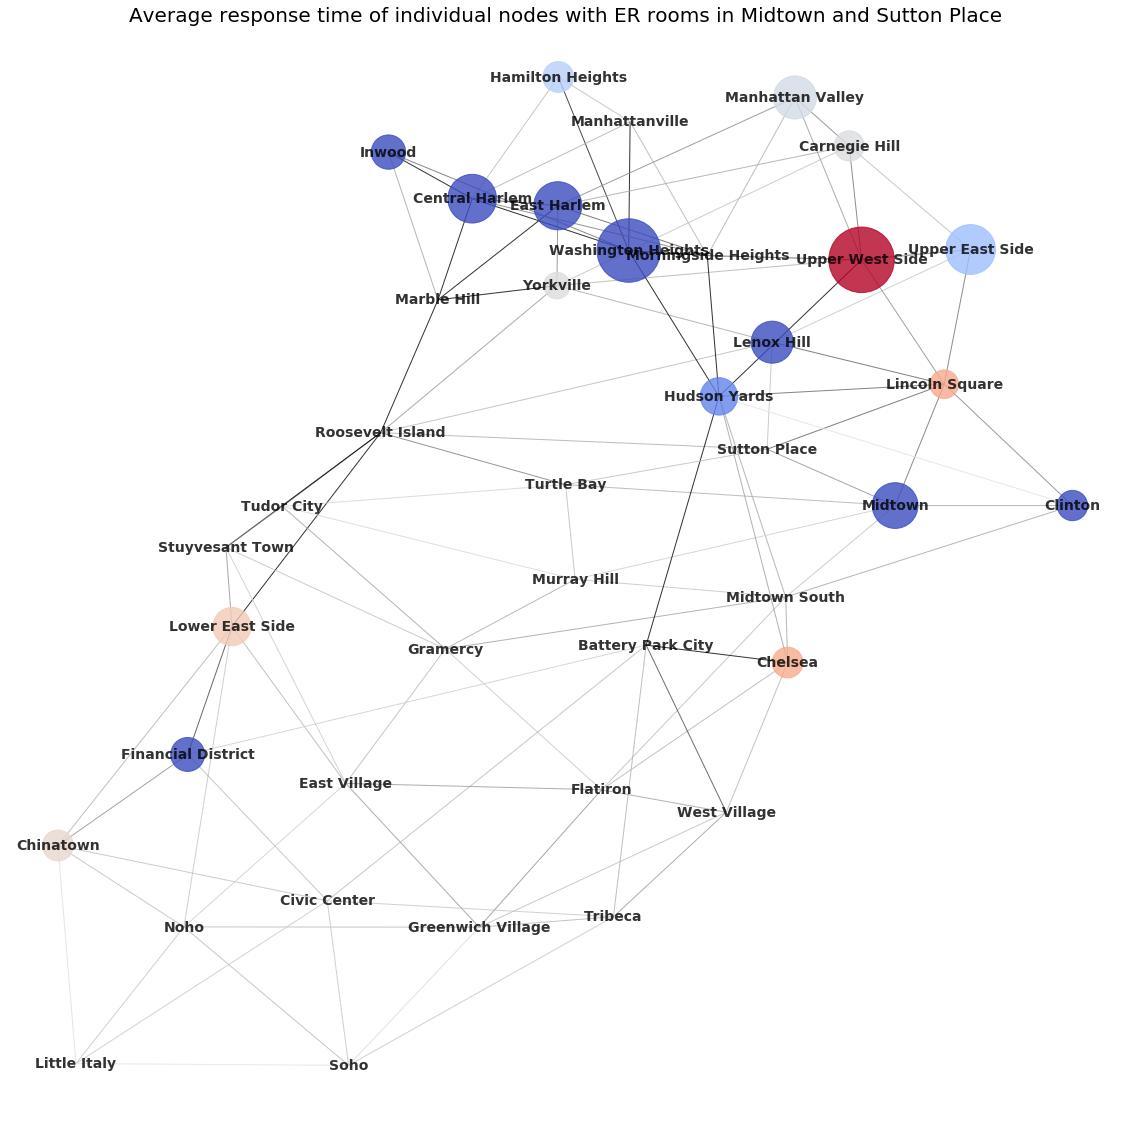

In [28]:
average_response_time_per_node = {key: 0 for key in G.nodes}
average_response_time_manhattan = []

for _ in range(500):  
    sim = Simulation(deepcopy(G),ambulance = True, ambulance_dict = ambulance_dict_new2)
    sim.depot_neighborhoods.append('Midtown')
    sim.depot_neighborhoods.append('Sutton Place')
    for i in range(360):
        sim.update()
    sim.converge()
    avg_node_time, node_time = sim.calc_response_time()
    
    # Add the average response time of Manhattan
    avg_node_time = np.mean([x for x in avg_node_time if x != None])
    average_response_time_manhattan.append(avg_node_time)
    
    # Add the average response time keyed by node.
    for key, value in node_time.items():
        average_response_time_per_node[key] += np.mean(value)


## Visualize the results

# For the entire network
plt.hist(average_response_time_manhattan, bins = 30, density = True)
plt.xlabel('Average response time of the network')
plt.ylabel('Density')
plt.title('Average response time with ER rooms in Midtown and Sutton Place')
plt.axvline(np.mean(average_response_time_manhattan), 
            label = 'Mean response time: %2f' % np.mean(average_response_time_manhattan), c = 'red')
plt.legend()
plt.show()

# For each node
plt.figure(figsize=(20,20))
average_response_time_per_node = {key: value/500 for key, value in average_response_time_per_node.items()}

layout = nx.spring_layout(G, iterations=200, k = 0.6)

node_size = list(nx.get_node_attributes(G,'population').values())
node_size = [s * 0.02 for s in node_size] # Node size proportional population

x_values, y_values = zip(*layout.values())
x_max = max(x_values)
x_min = min(x_values)
y_max = max(y_values)
y_min = min(y_values)
x_margin = (x_max - x_min) * 0.05
y_margin = (y_max - y_min) * 0.05
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.ylim(y_min - y_margin, y_max + y_margin)

nx.draw(
    G, pos=layout, with_labels=True,
    node_size = node_size,
    node_color=[average_response_time_per_node[i] for i in G.nodes],
    cmap = plt.cm.coolwarm,
    font_size = 14,
    edge_color=[G.edges[i, j]['weight'] for i, j in G.edges],
    edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=5000,
    alpha=0.8, font_weight = 'bold', #vmin=0, vmax=1
    )

plt.title('Average response time of individual nodes with ER rooms in Midtown and Sutton Place', size = 20)
plt.show()

In [29]:
ambulance_dict_new3 = {
        'Washington Heights':20, 'Central Harlem':5, 'Morningside Heights':5, 'East Harlem':15,
        'Lenox Hill':10, 'Financial District':5, 'Greenwich Village':5 ,'Clinton':5, 'Stuyvesant Town':5,
        'Gramercy':10, 'Inwood': 5, 'Midtown': 5, 'Upper West Side': 5
           }

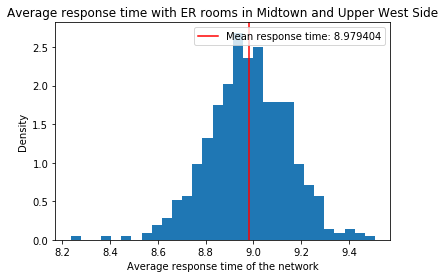

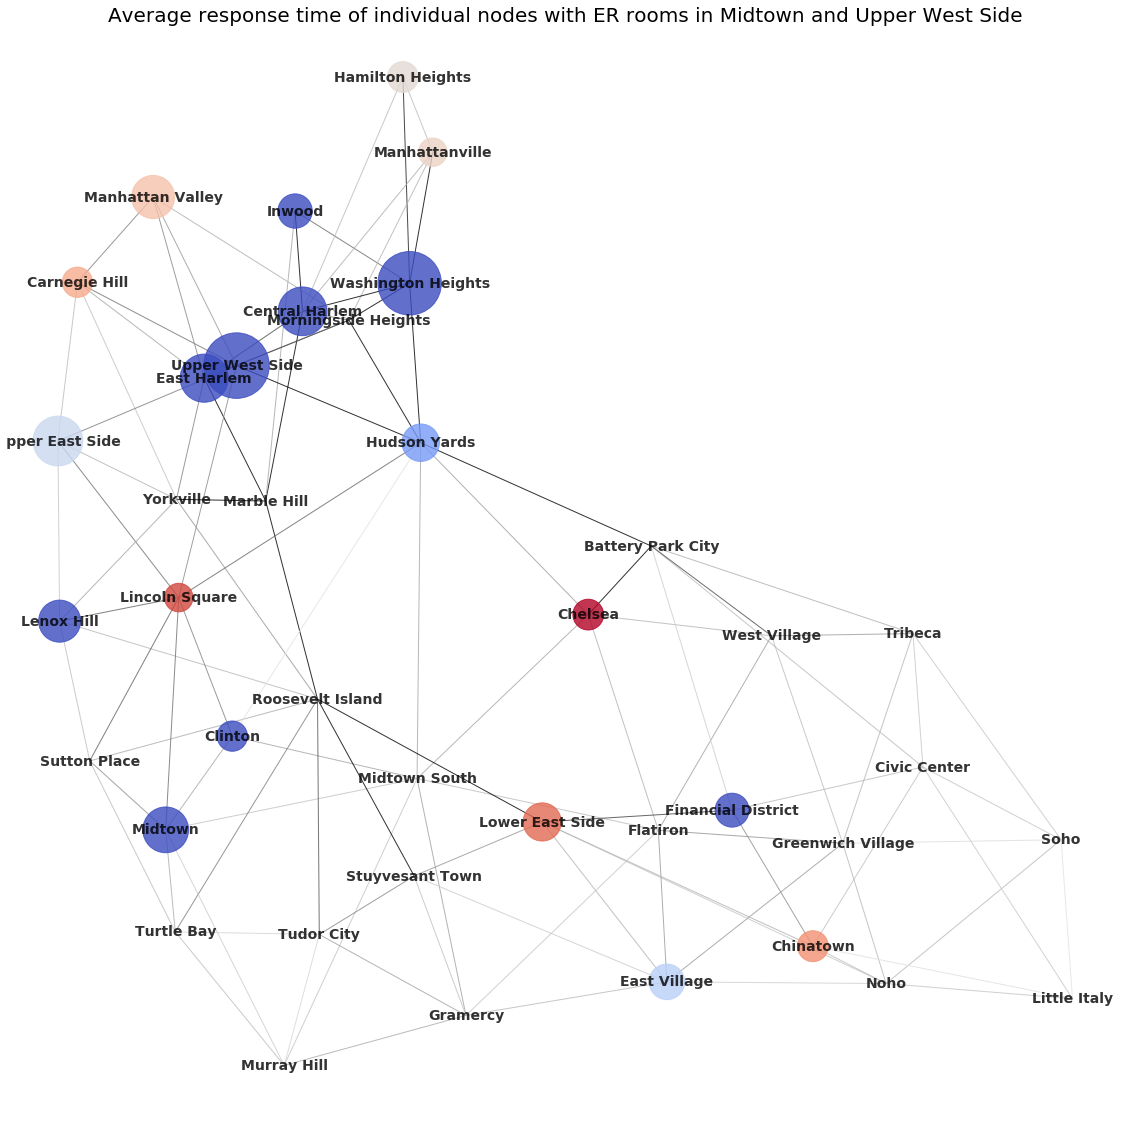

In [30]:
average_response_time_per_node = {key: 0 for key in G.nodes}
average_response_time_manhattan = []

for _ in range(500):  
    sim = Simulation(deepcopy(G),ambulance = True, ambulance_dict = ambulance_dict_new3)
    sim.depot_neighborhoods.append('Midtown')
    sim.depot_neighborhoods.append('Upper West Side')
    for i in range(360):
        sim.update()
    sim.converge()
    avg_node_time, node_time = sim.calc_response_time()
    
    # Add the average response time of Manhattan
    avg_node_time = np.mean([x for x in avg_node_time if x != None])
    average_response_time_manhattan.append(avg_node_time)
    
    # Add the average response time keyed by node.
    for key, value in node_time.items():
        average_response_time_per_node[key] += np.mean(value)


## Visualize the results

# For the entire network
plt.hist(average_response_time_manhattan, bins = 30, density = True)
plt.xlabel('Average response time of the network')
plt.ylabel('Density')
plt.title('Average response time with ER rooms in Midtown and Upper West Side')
plt.axvline(np.mean(average_response_time_manhattan), 
            label = 'Mean response time: %2f' % np.mean(average_response_time_manhattan), c = 'red')
plt.legend()
plt.show()

# For each node
plt.figure(figsize=(20,20))
average_response_time_per_node = {key: value/500 for key, value in average_response_time_per_node.items()}

layout = nx.spring_layout(G, iterations=200, k = 0.6)

node_size = list(nx.get_node_attributes(G,'population').values())
node_size = [s * 0.02 for s in node_size] # Node size proportional population

x_values, y_values = zip(*layout.values())
x_max = max(x_values)
x_min = min(x_values)
y_max = max(y_values)
y_min = min(y_values)
x_margin = (x_max - x_min) * 0.05
y_margin = (y_max - y_min) * 0.05
plt.xlim(x_min - x_margin, x_max + x_margin)
plt.ylim(y_min - y_margin, y_max + y_margin)

nx.draw(
    G, pos=layout, with_labels=True,
    node_size = node_size,
    node_color=[average_response_time_per_node[i] for i in G.nodes],
    cmap = plt.cm.coolwarm,
    font_size = 14,
    edge_color=[G.edges[i, j]['weight'] for i, j in G.edges],
    edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=5000,
    alpha=0.8, font_weight = 'bold', #vmin=0, vmax=1
    )

plt.title('Average response time of individual nodes with ER rooms in Midtown and Upper West Side', size = 20)
plt.show()